In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")


In [5]:
# Dosya adını kendi indirdiğin dosya adıyla değiştir
df = pd.read_csv("cards.csv", encoding="ISO-8859-1")


# İlk 5 satıra bakalım
df.head()


,card_id,playerClass,type,name,set,text,cost,attack,health,rarity,collectible,flavor,race,how_to_earn,how_to_earn_golden,targeting_arrow_text,faction,durability
0,KARA_00_07,MAGE,SPELL,Astral Portal,KARA,Summon a random <b>Legendary</b> minion.,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NEW1_008a,DRUID,SPELL,Ancient Teachings,EXPERT1,Draw a card.,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BRM_010t2,DRUID,MINION,Druid of the Flame,BRM,NaN,3.0,2.0,5.0,COMMON,NaN,NaN,BEAST,NaN,NaN,NaN,NaN,NaN
3,AT_132,NEUTRAL,MINION,Justicar Trueheart,TGT,<b>Battlecry:</b> Replace your starting Hero P...,6.0,6.0,3.0,LEGENDARY,True,It's like putting racing stripes and a giant s...,NaN,NaN,NaN,NaN,NaN,NaN
4,OG_141,NEUTRAL,MINION,Faceless Behemoth,OG,NaN,10.0,10.0,10.0,COMMON,True,"Rejected names: Forty-Foot Faceless, Big ol' N...",NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# temel bilgiler
# Veri setinin yapısı
df.info()

# Eksik verileri kontrol et
df.isnull().sum()

# Benzersiz deck türü var mı bakalım (eğer varsa)
if "deck" in df.columns:
    print(df["deck"].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2819 entries, 0 to 2818
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   card_id               2819 non-null   object 
 1   playerClass           2816 non-null   object 
 2   type                  2818 non-null   object 
 3   name                  2818 non-null   object 
 4   set                   2818 non-null   object 
 5   text                  2386 non-null   object 
 6   cost                  2168 non-null   float64
 7   attack                1258 non-null   float64
 8   health                1368 non-null   float64
 9   rarity                1399 non-null   object 
 10  collectible           1070 non-null   object 
 11  flavor                1056 non-null   object 
 12  race                  328 non-null    object 
 13  how_to_earn           245 non-null    object 
 14  how_to_earn_golden    290 non-null    object 
 15  targeting_arrow_text 

In [7]:
# Kart açıklamalarından bazı örnekler
if "text" in df.columns:
    for i in range(5):
        print(f"\nKart: {df.iloc[i]['name']}")
        print(f"Açıklama: {df.iloc[i]['text']}")



Kart: Astral Portal
Açıklama: Summon a random <b>Legendary</b> minion.

Kart: Ancient Teachings
Açıklama: Draw a card.

Kart: Druid of the Flame
Açıklama: nan

Kart: Justicar Trueheart
Açıklama: <b>Battlecry:</b> Replace your starting Hero Power with a better one.

Kart: Faceless Behemoth
Açıklama: nan


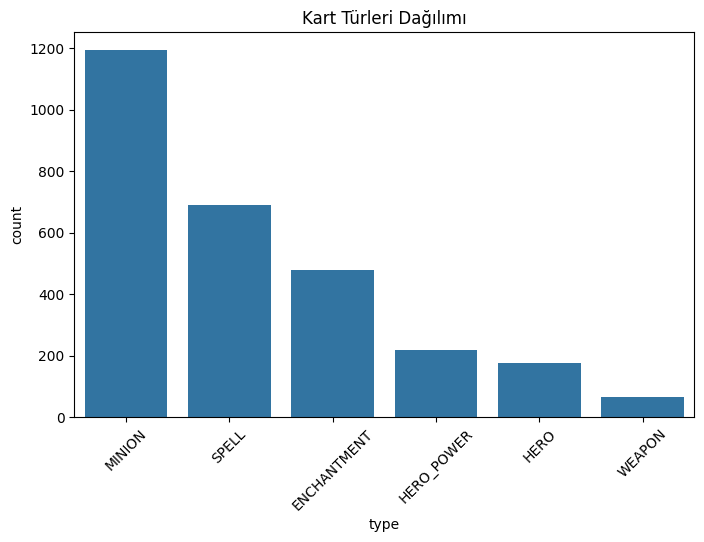

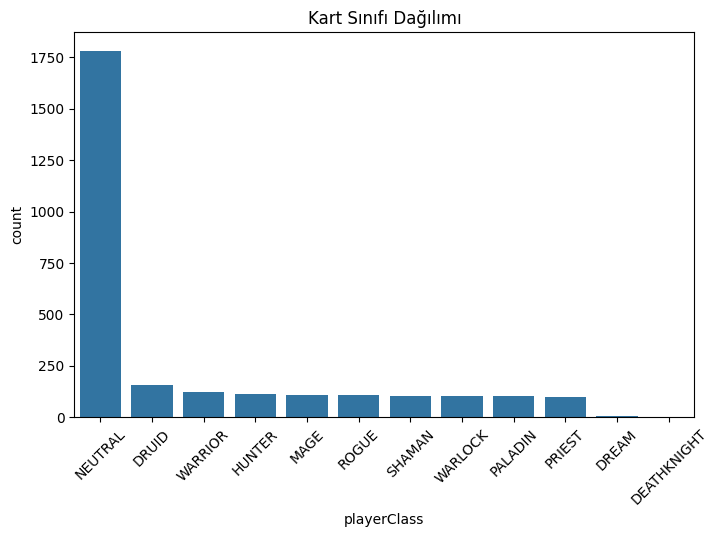

In [8]:
# Kart türleri
if "type" in df.columns:
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x="type", order=df["type"].value_counts().index)
    plt.title("Kart Türleri Dağılımı")
    plt.xticks(rotation=45)
    plt.show()

# Kart sınıfları (mage, hunter vs.)
if "playerClass" in df.columns:
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x="playerClass", order=df["playerClass"].value_counts().index)
    plt.title("Kart Sınıfı Dağılımı")
    plt.xticks(rotation=45)
    plt.show()


In [9]:
# Kaç kartta açıklama (text) eksik?
df["text"].isnull().sum()


np.int64(433)

In [10]:
df = df.dropna(subset=["text"])


In [11]:
import re

def clean_html(raw_text):
    clean_text = re.sub(r'<.*?>', '', str(raw_text))  # HTML taglerini temizle
    return clean_text

df["clean_text"] = df["text"].apply(clean_html)


In [12]:
import string

def preprocess_text(text):
    # Küçük harfe çevir
    text = text.lower()
    # Noktalama işaretlerini kaldır
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df["clean_text"] = df["clean_text"].apply(preprocess_text)


In [14]:
target_column = "playerClass"  # Hunter, Mage, Rogue vs.



In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vektörleştirici oluştur
vectorizer = TfidfVectorizer(max_features=3000)  # 3000 en iyi kelime

# Temizlenmiş açıklamaları vektörleştir
X = vectorizer.fit_transform(df["clean_text"])

# Hedef sınıf
y = df["playerClass"]


In [17]:
print("X içinde NaN:", np.any(pd.isnull(X.toarray())))
print("y içinde NaN:", y.isnull().sum())


X içinde NaN: False
y içinde NaN: 2


In [20]:
# Her sınıftan kaç tane kart olduğunu say
class_counts = df["playerClass"].value_counts()

# Sadece en az 2 örneğe sahip sınıfları filtrele
valid_classes = class_counts[class_counts > 1].index

# Bu geçerli sınıflarla veri setini filtrele
df = df[df["playerClass"].isin(valid_classes)]


In [21]:
# Yine X ve y oluştur
X = vectorizer.fit_transform(df["clean_text"])
y = df["playerClass"]

# Bu sefer stratify sorunsuz çalışacaktır
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Modeli oluştur
model = LogisticRegression(max_iter=1000)

# Eğit
model.fit(X_train, y_train)

# Tahmin yap
y_pred = model.predict(X_test)

# Performans değerlendirme
print("🎯 Doğruluk Oranı (Accuracy):", accuracy_score(y_test, y_pred))
print("\n📋 Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))


🎯 Doğruluk Oranı (Accuracy): 0.6310272536687631

📋 Sınıflandırma Raporu:
               precision    recall  f1-score   support

       DREAM       0.00      0.00      0.00         1
       DRUID       0.80      0.14      0.24        29
      HUNTER       0.50      0.05      0.09        20
        MAGE       0.00      0.00      0.00        19
     NEUTRAL       0.63      1.00      0.77       290
     PALADIN       0.00      0.00      0.00        19
      PRIEST       0.00      0.00      0.00        19
       ROGUE       1.00      0.15      0.26        20
      SHAMAN       1.00      0.05      0.10        20
     WARLOCK       1.00      0.06      0.11        18
     WARRIOR       0.50      0.05      0.08        22

    accuracy                           0.63       477
   macro avg       0.49      0.14      0.15       477
weighted avg       0.60      0.63      0.51       477



In [23]:
def predict_class(example_text):
    cleaned = preprocess_text(clean_html(example_text))
    vectorized = vectorizer.transform([cleaned])
    return model.predict(vectorized)[0]

# Deneme
kart_aciklamasi = "Deal 3 damage to all enemy minions."
tahmin = predict_class(kart_aciklamasi)
print("🔮 Tahmin Edilen Sınıf:", tahmin)


🔮 Tahmin Edilen Sınıf: NEUTRAL


In [24]:
import joblib

# Modeli ve TF-IDF vektörleştiriciyi kaydet
joblib.dump(model, "hearthstone_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [ ]:
g